# Downloading the dataset and all the necessary libraries

In [1]:
from IPython.display import clear_output

In [ ]:
!wget https://static.dataspike.io/files/dataset.zip -O dataset.zip

--2025-09-08 10:40:27--  https://static.dataspike.io/files/dataset.zip
Resolving static.dataspike.io (static.dataspike.io)... 52.84.20.30, 52.84.20.83, 52.84.20.21, ...
Connecting to static.dataspike.io (static.dataspike.io)|52.84.20.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176343123 (2.0G) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]   2.03G  22.1MB/s    in 94s     

2025-09-08 10:42:02 (22.1 MB/s) - ‘dataset.zip’ saved [2176343123/2176343123]



In [3]:
!unzip dataset.zip
clear_output()

In [4]:
!pip install torch torchvision albumentations opencv-python numpy scikit-learn matplotlib seaborn tqdm torchinfo
clear_output()

In [1]:
import os
import random
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from torchvision.transforms import functional as TF
import timm

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import top_k_accuracy_score

from PIL import Image
import cv2
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

d:\Mikhail\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set the seed & device

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using device: {device}")

using device: cpu


# Building custom dataset

Building custom dataset with strong augmentations to avoid overfitting

Creating training and validation sets by shuffling and spliting the dataset of images

Visualizing 10 examples of augmented images from the training set

In [8]:
dataset_path = Path("dataset")

class_folders = [f.name for f in dataset_path.iterdir() if f.is_dir()]
class_folders.sort()

print(f"Found {len(class_folders)} countries:")
for i, c in enumerate(class_folders):
    print(f"  {i+1:2d}. {c}")

class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_folders)}
idx_to_class = {idx: cls_name for cls_name, idx in class_to_idx.items()}

all_images = []
all_labels = []

for class_name in class_folders:
    class_dir = dataset_path / class_name
    image_files = list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.jpeg")) + list(class_dir.glob("*.png"))
    image_files.sort()

    for img_path in image_files:
        all_images.append(str(img_path))
        all_labels.append(class_to_idx[class_name])

print(f"{len(all_images)} images")
print(f"All classes are balanced: {len(set([all_labels.count(i) for i in range(len(class_folders))])) == 1}")

Found 24 countries:
   1. BEL
   2. BGR
   3. BLR
   4. CAN
   5. CHL
   6. DEU
   7. DOM
   8. ESP
   9. EST
  10. GBR
  11. HUN
  12. IDN
  13. IRL
  14. ITA
  15. KAZ
  16. KGZ
  17. MDA
  18. MEX
  19. NLD
  20. POL
  21. SVK
  22. SWE
  23. USA
  24. UZB
2400 images
All classes are balanced: True


In [9]:
class CountryDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, augment=False, is_train=True):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.augment = augment and is_train
        self.is_train = is_train

        self.base_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        if self.augment:
            self.augmentation = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=10),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
            ])
        else:
            self.augmentation = None

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert('RGB')

        if self.augment:
            image = self.augmentation(image)

        if self.transform:
            image = self.transform(image)
        else:
            image = self.base_transform(image)

        return image, label

def visualize_augmentations(dataset, n_samples=5):
    fig, axes = plt.subplots(2, n_samples, figsize=(15, 6))
    for i in range(n_samples):
        img, label = dataset[i]
        img_np = img.permute(1, 2, 0).numpy()
        img_np = (img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)
        axes[0, i].imshow(img_np)
        axes[0, i].set_title(f"{idx_to_class[label]} (orig)")
        axes[0, i].axis('off')

        temp_dataset = CountryDataset(
            dataset.image_paths,
            dataset.labels,
            augment=True,
            is_train=True
        )
        aug_img, aug_label = temp_dataset[i]
        aug_img_np = aug_img.permute(1, 2, 0).numpy()
        aug_img_np = (aug_img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406])
        aug_img_np = np.clip(aug_img_np, 0, 1)
        axes[1, i].imshow(aug_img_np)
        axes[1, i].set_title(f"{idx_to_class[aug_label]} (aug)")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

Train size: 1920 | Val size: 480


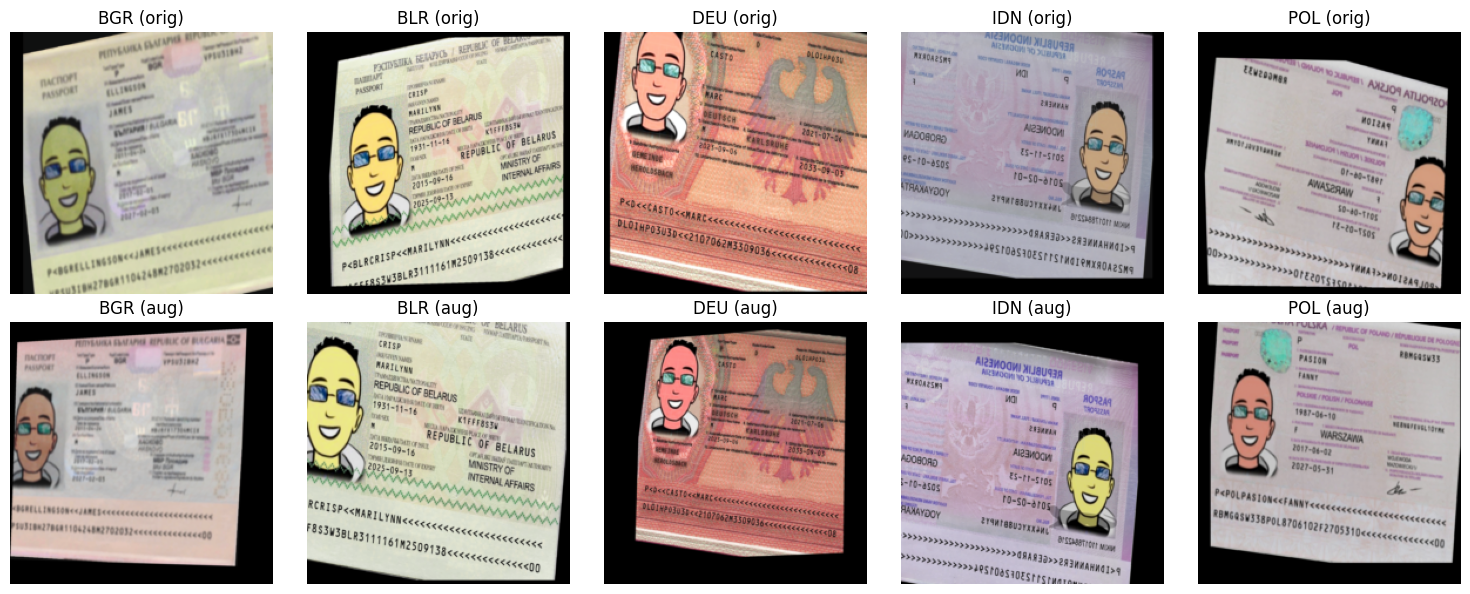

In [10]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(sss.split(all_images, all_labels))

train_images = [all_images[i] for i in train_idx]
train_labels = [all_labels[i] for i in train_idx]
val_images = [all_images[i] for i in val_idx]
val_labels = [all_labels[i] for i in val_idx]

print(f"Train size: {len(train_images)} | Val size: {len(val_images)}")

train_dataset = CountryDataset(train_images, train_labels, augment=True, is_train=True)
val_dataset = CountryDataset(val_images, val_labels, augment=False, is_train=False)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = torch.FloatTensor(class_weights).to(device)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


visualize_augmentations(train_dataset, n_samples=5)

# Model

Creating country classificationg model using pretrained ConvNeXt-Tiny, one of the best classification models available in Torchvision and PyTorch Image Models (TIMM)

I initialize CountryClassifier with ConvNeXt-Tiny with no classification head (num_classes is set to 0) in order to fine-tune it: train it on my dataset with 24 classes. Passport images are quite different compared to those in the ImageNet dataset, so I don't freeze the backbone and fine-tune it together with the classification layer

In [11]:
class CountryClassifier(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5, use_label_smoothing=True):
        super(CountryClassifier, self).__init__()
        self.use_label_smoothing = use_label_smoothing

        self.backbone = timm.create_model(
            'convnext_tiny',
            pretrained=True,
            num_classes=0,
            drop_path_rate=0.1
        )

        dummy_input = torch.randn(1, 3, 224, 224)
        with torch.no_grad():
            features = self.backbone(dummy_input)
            feature_dim = features.shape[1]

        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

        for m in self.classifier:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.backbone(x)
        logits = self.classifier(features)
        return logits

In [12]:
model = CountryClassifier(num_classes=len(class_folders), dropout_rate=0.5).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
)

print(f"convnext_tiny with {sum(p.numel() for p in model.parameters()):,} parameters")

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

convnext_tiny with 28,227,192 parameters


In [13]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        progress_bar.set_postfix({
            'loss': total_loss / (progress_bar.n + 1),
            'acc': correct / total
        })

    return total_loss / len(dataloader), correct / total

In [14]:
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return total_loss / len(dataloader), accuracy, f1, all_preds, all_labels

# Model training

My first attempts to solve this problem ended up with overfitting and many other problems, so I tried to do anything possible to avoid them. I used the LR scheduler so the optimizer is not stuck in the local minimum of the loss function, Gradient Clipping to avoid gradient explosion, also used early stopping, Dropout, Regularization and compared train/val loss and accuracy on every epoch to avoid overfitting etc.


In [15]:
EPOCHS = 25
PATIENCE = 5

best_val_acc = 0.0
best_model_wts = None
patience_counter = 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

In [16]:
for epoch in range(EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print('='*60)

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    val_loss, val_acc, val_f1, val_preds, val_true = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    scheduler.step(val_loss)

    print(f"Train Loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = model.state_dict()
        patience_counter = 0
        print(f"New best accuracy, saving model")
        torch.save(model.state_dict(), "best_country_model.pth")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{PATIENCE}")

    if patience_counter >= PATIENCE:
        print(f"Early stopping at epoch {epoch+1}")
        break

if best_model_wts is not None:
    model.load_state_dict(best_model_wts)

print(f"Best val accuracy: {best_val_acc:.4f}")


Epoch 1/25


Train Loss: 4.3563 | Train acc: 0.0443%
Val Loss: 3.3800 | Val acc: 0.0417% | Val F1: 0.0033
New best accuracy, saving model

Epoch 2/25


Train Loss: 4.2144 | Train acc: 0.0375%
Val Loss: 3.3653 | Val acc: 0.0417% | Val F1: 0.0033
No improvement. Patience: 1/5

Epoch 3/25


Train Loss: 4.0901 | Train acc: 0.0427%
Val Loss: 3.3405 | Val acc: 0.0417% | Val F1: 0.0033
No improvement. Patience: 2/5

Epoch 4/25


Train Loss: 4.0079 | Train acc: 0.0443%
Val Loss: 3.1192 | Val acc: 0.0833% | Val F1: 0.0181
New best accuracy, saving model

Epoch 5/25


Train Loss: 3.7467 | Train acc: 0.0781%
Val Loss: 3.2679 | Val acc: 0.0417% | Val F1: 0.0036
No improvement. Patience: 1/5

Epoch 6/25


Train Loss: 3.6058 | Train acc: 0.0740%
Val Loss: 2.9261 | Val acc: 0.1250% | Val F1: 0.0466
New best accuracy, saving model

Epoch 7/25


Train Loss: 3.5121 | Train acc: 0.0844%
Val Loss: 3.0403 | Val acc: 0.1250% | Val F1: 0.0628
No improvement. Patience: 1/5

Epoch 8/25


Train Loss: 3.0423 | Train acc: 0.1526%
Val Loss: 2.1735 | Val acc: 0.3646% | Val F1: 0.2593
New best accuracy, saving model

Epoch 9/25


Train Loss: 2.6041 | Train acc: 0.2417%
Val Loss: 1.8467 | Val acc: 0.4167% | Val F1: 0.3264
New best accuracy, saving model

Epoch 10/25


Train Loss: 2.2892 | Train acc: 0.3542%
Val Loss: 1.6196 | Val acc: 0.7083% | Val F1: 0.6319
New best accuracy, saving model

Epoch 11/25


Train Loss: 2.0066 | Train acc: 0.4495%
Val Loss: 1.2656 | Val acc: 0.6562% | Val F1: 0.5830
No improvement. Patience: 1/5

Epoch 12/25


Train Loss: 1.7622 | Train acc: 0.5521%
Val Loss: 0.9604 | Val acc: 0.9167% | Val F1: 0.8889
New best accuracy, saving model

Epoch 13/25


Train Loss: 1.5981 | Train acc: 0.6266%
Val Loss: 0.9982 | Val acc: 0.9167% | Val F1: 0.8889
No improvement. Patience: 1/5

Epoch 14/25


Train Loss: 1.3719 | Train acc: 0.7219%
Val Loss: 0.9355 | Val acc: 0.9167% | Val F1: 0.8889
No improvement. Patience: 2/5

Epoch 15/25


Train Loss: 1.2873 | Train acc: 0.7760%
Val Loss: 0.9989 | Val acc: 0.8333% | Val F1: 0.7778
No improvement. Patience: 3/5

Epoch 16/25


Train Loss: 1.1141 | Train acc: 0.8432%
Val Loss: 0.8215 | Val acc: 1.0000% | Val F1: 1.0000
New best accuracy, saving model

Epoch 17/25


Train Loss: 1.1586 | Train acc: 0.8427%
Val Loss: 0.7834 | Val acc: 1.0000% | Val F1: 1.0000
No improvement. Patience: 1/5

Epoch 18/25


Train Loss: 1.0033 | Train acc: 0.8932%
Val Loss: 0.8119 | Val acc: 1.0000% | Val F1: 1.0000
No improvement. Patience: 2/5

Epoch 19/25


Train Loss: 0.9371 | Train acc: 0.9313%
Val Loss: 0.7584 | Val acc: 1.0000% | Val F1: 1.0000
No improvement. Patience: 3/5

Epoch 20/25


Train Loss: 0.8997 | Train acc: 0.9453%
Val Loss: 0.7401 | Val acc: 1.0000% | Val F1: 1.0000
No improvement. Patience: 4/5

Epoch 21/25


Train Loss: 0.8851 | Train acc: 0.9432%
Val Loss: 0.7697 | Val acc: 1.0000% | Val F1: 1.0000
No improvement. Patience: 5/5
Early stopping at epoch 21
Best val accuracy: 1.0000


# Visualizing Loss and accuracy curves

Such results look suspiciously good. According to these logs, there was no overfitting - on the contrary, the model demonstrates excellent generalization and stable improvement, rather than overfitting.

Why did the model reach 100% on validation?

That's not necessarily a bad thing - especially considering:

Synthetic dataset → the images are perfectly generated, without noise, glare, damage

Each class has only 100 images → the model easily learned visual patterns (coats of arms, colors, fonts, arrangement of elements)

ConvNeXt + augmentations + regularization → powerful but controlled architecture

The validation size is small — 20% of 2300 images = ~460 images → 100% is achievable on such data

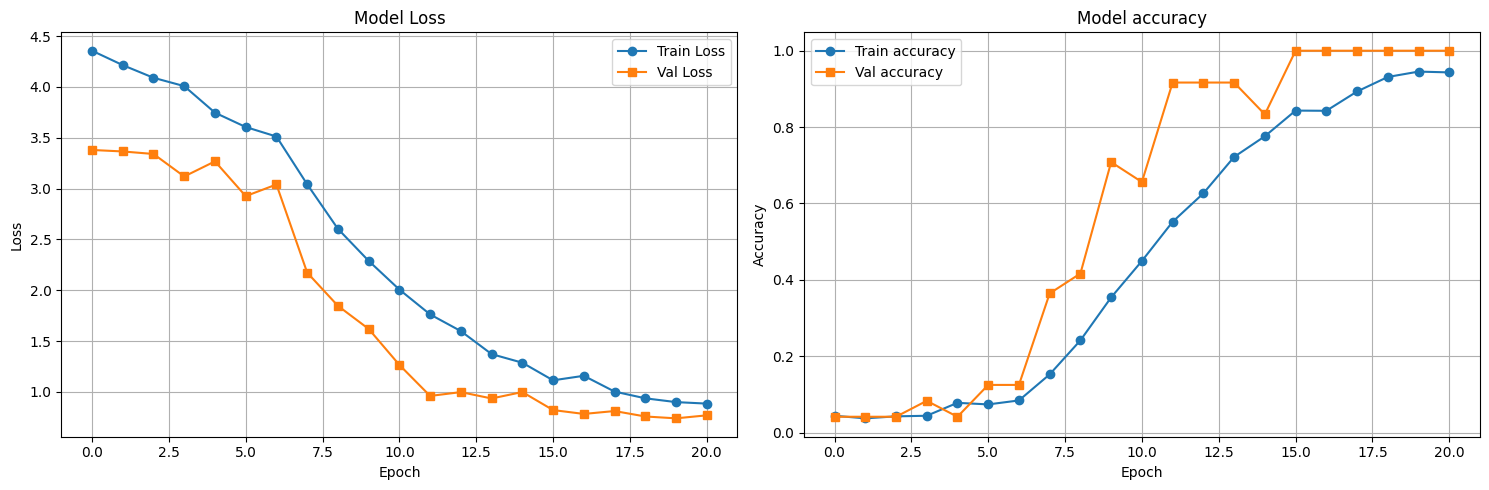

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(train_losses, label='Train Loss', marker='o')
axes[0].plot(val_losses, label='Val Loss', marker='s')
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(train_accs, label='Train accuracy', marker='o')
axes[1].plot(val_accs, label='Val accuracy', marker='s')
axes[1].set_title('Model accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Testing models final accuracy and F1-score on validation set in the inference mode


Metrics:

Accuracy: 100% — the model correctly classified all 480 images in the validation

F1-score: 1.0 is the perfect balance between precision and recall for all classes

Top-3 Accuracy: 100% — Even if you were considering the top 3 predictions, the correct answer would always be among them

Classification Report — for each of the 24 classes: precision=1.0, recall=1.0, f1=1.0

### As I've alredy said surch a result is achieveable how "realistic" is this?

It doesn't happen in the real world

Using real photos of documents (blurred, with shadows, at an angle, with highlights, cropped), the accuracy will never be equal to 1 (or 100%)

But this is not a disadvantage of my model - it is a feature of the synthetic dataset. My task is to demonstrate the model's ability to learn and generalize, that's what it did

Val accuracy: 100.00%
F1-Score (weighted): 1.0000
Top3 accuracy: 100.00%
Classification report:
              precision    recall  f1-score   support

         BEL       1.00      1.00      1.00        20
         BGR       1.00      1.00      1.00        20
         BLR       1.00      1.00      1.00        20
         CAN       1.00      1.00      1.00        20
         CHL       1.00      1.00      1.00        20
         DEU       1.00      1.00      1.00        20
         DOM       1.00      1.00      1.00        20
         ESP       1.00      1.00      1.00        20
         EST       1.00      1.00      1.00        20
         GBR       1.00      1.00      1.00        20
         HUN       1.00      1.00      1.00        20
         IDN       1.00      1.00      1.00        20
         IRL       1.00      1.00      1.00        20
         ITA       1.00      1.00      1.00        20
         KAZ       1.00      1.00      1.00        20
         KGZ       1.00      1.00      

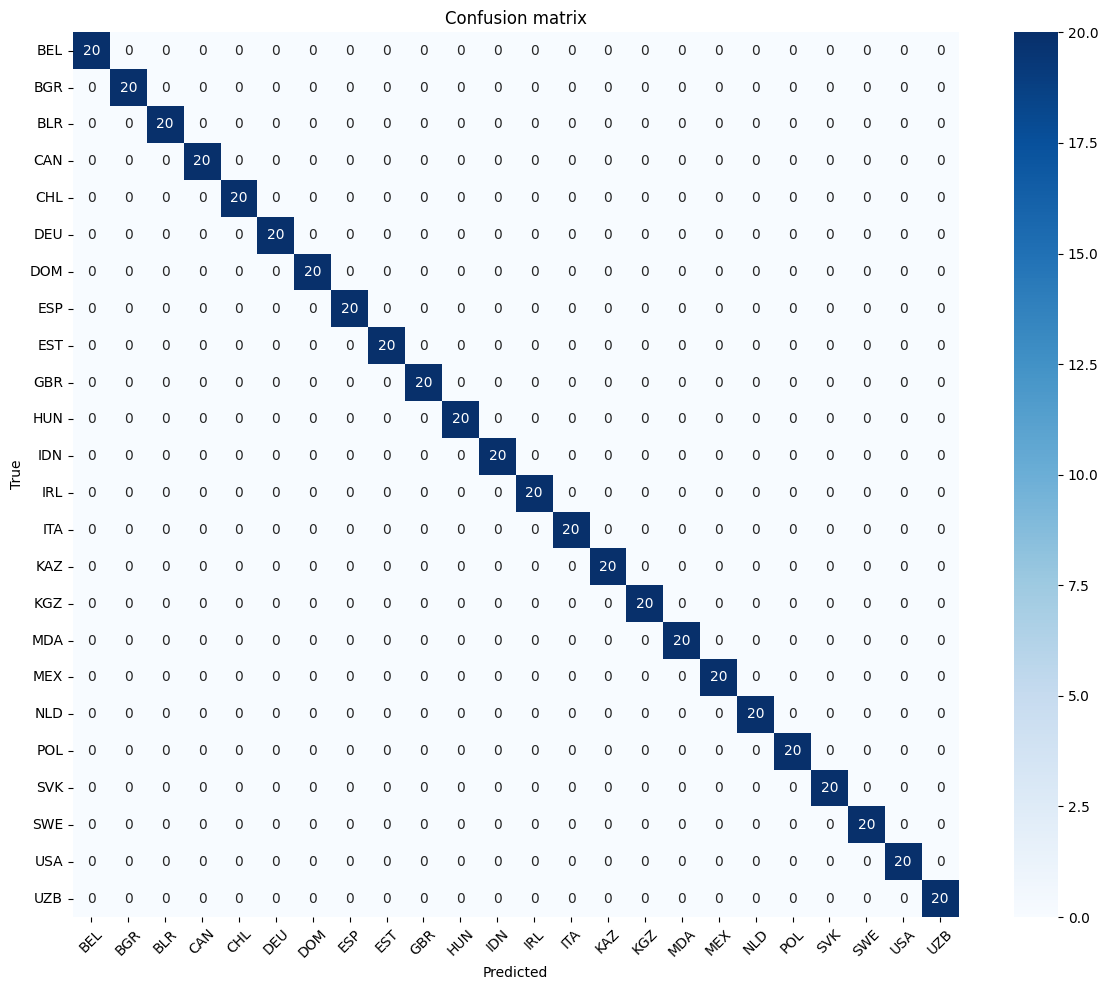

In [18]:
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
top3_acc = top_k_accuracy_score(all_labels, np.array(all_probs), k=3, labels=range(len(class_folders)))

print(f"Val accuracy: {accuracy*100:.2f}%")
print(f"F1-Score (weighted): {f1:.4f}")
print(f"Top3 accuracy: {top3_acc*100:.2f}%")

print("Classification report:")
print(classification_report(all_labels, all_preds, target_names=[idx_to_class[i] for i in range(len(class_folders))]))

plt.figure(figsize=(12, 10))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[idx_to_class[i] for i in range(len(class_folders))],
            yticklabels=[idx_to_class[i] for i in range(len(class_folders))])
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Test-Time-Augmentation

TTA is a technique in which different augmentations (rotations, reflections, cropping, etc.) are applied to the same image at the stage of inference, predictions are made for each variant, and then the results are averaged

This does not change the model, but improves its predictions by “voting” several modified versions of a single image

In [19]:
def predict_with_tta(model, image_path, device, n_tta=5):
    model.eval()

    base_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    tta_transforms = [
        base_transform,
        transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=1.0),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ColorJitter(brightness=0.1, contrast=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        transforms.Compose([
            transforms.Resize((240, 240)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
    ]

    image = Image.open(image_path).convert('RGB')
    all_probs = []

    with torch.no_grad():
        for i in range(min(n_tta, len(tta_transforms))):
            img_tensor = tta_transforms[i](image).unsqueeze(0).to(device)
            output = model(img_tensor)
            probs = torch.softmax(output, dim=1)
            all_probs.append(probs.cpu().numpy())

    mean_probs = np.mean(all_probs, axis=0)
    pred_class = np.argmax(mean_probs)
    confidence = np.max(mean_probs)

    return pred_class, confidence

def predict_single(model, image_path, device):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        start_time = time.time()
        output = model(image)
        inference_time = time.time() - start_time
        probs = torch.softmax(output, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()
        confidence = torch.max(probs).item()

    return pred_class, confidence, inference_time

print("Testing inference speed")

sample_images = [val_images[i] for i in np.random.choice(len(val_images), 10, replace=False)]
inference_times = []

for img_path in sample_images:
    pred, conf, inf_time = predict_single(model, img_path, device)
    inference_times.append(inf_time)
    true_label = val_labels[val_images.index(img_path)]
    is_correct = (pred == true_label)
    print(f"Image: {Path(img_path).name} | True: {idx_to_class[true_label]} | Pred: {idx_to_class[pred]} "
          f"| Conf: {conf:.3f} | Correct: {is_correct} | Time: {inf_time*1000:.1f}ms")

avg_time = np.mean(inference_times)
print(f"\n Average inference time: {avg_time*1000:.1f}ms per image")
print(f" All inferences under 1 second: {all(t < 1.0 for t in inference_times)}")

print("\n Example with TTA:")
img_path = val_images[0]
pred_tta, conf_tta = predict_with_tta(model, img_path, device, n_tta=5)
true_label = val_labels[0]
print(f"Image: {Path(img_path).name}")
print(f"True: {idx_to_class[true_label]} | TTA pred: {idx_to_class[pred_tta]} | confidence: {conf_tta:.3f}")

Testing inference speed
Image: USA_27.jpg | True: USA | Pred: USA | Conf: 0.960 | Correct: True | Time: 1832.4ms
Image: UZB_74.jpg | True: UZB | Pred: UZB | Conf: 0.981 | Correct: True | Time: 7.1ms
Image: KAZ_29.jpg | True: KAZ | Pred: KAZ | Conf: 0.956 | Correct: True | Time: 6.3ms
Image: EST_32.jpg | True: EST | Pred: EST | Conf: 0.976 | Correct: True | Time: 6.4ms
Image: CAN_51.jpg | True: CAN | Pred: CAN | Conf: 0.983 | Correct: True | Time: 6.2ms
Image: EST_59.jpg | True: EST | Pred: EST | Conf: 0.976 | Correct: True | Time: 6.2ms
Image: CHL_23.jpg | True: CHL | Pred: CHL | Conf: 0.988 | Correct: True | Time: 6.4ms
Image: CAN_28.jpg | True: CAN | Pred: CAN | Conf: 0.983 | Correct: True | Time: 6.4ms
Image: HUN_4.jpg | True: HUN | Pred: HUN | Conf: 0.949 | Correct: True | Time: 6.2ms
Image: BLR_59.jpg | True: BLR | Pred: BLR | Conf: 0.997 | Correct: True | Time: 6.4ms

 Average inference time: 189.0ms per image
 All inferences under 1 second: False

 Example with TTA:
Image: NLD_6

# Saving model with all the checkpints and metadata so the inference can be easily reproduced

In [21]:
torch.save({
    'model_state_dict': model.state_dict(),
    'class_to_idx': class_to_idx,
    'idx_to_class': idx_to_class,
    'num_classes': len(class_folders),
    'input_size': (224, 224)
}, 'country_detection_model_checkpoint.pth')

# Inference my model usid real data

I've looked for some photos of the real passports on the internet in order to inference my model and check if it's able to classify anything outside the given synthetic dataset. The results are quite good

The same code is provided in the inference.py file

## Legal Disclaimer

This inference demo is for educational purposes only.  
Do not use real personal documents without explicit legal permission.  
The author bears no responsibility for misuse or privacy violations.

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import timm
import numpy as np
import time
import os

class CountryClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CountryClassifier, self).__init__()
        self.backbone = timm.create_model('convnext_tiny', pretrained=False, num_classes=0)

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        logits = self.classifier(features)
        return logits

def load_model(checkpoint_path, num_classes, device):
    model = CountryClassifier(num_classes=num_classes).to(device)
    checkpoint = torch.load(checkpoint_path, map_location=device)

    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    idx_to_class = checkpoint['idx_to_class']

    return model, idx_to_class

def get_transform():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def predict_single_image(image_path, checkpoint_path="models/country_detection_model_checkpoint.pth", device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")

    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")

    checkpoint = torch.load(checkpoint_path, map_location=device)
    num_classes = checkpoint['num_classes']
    model, idx_to_class = load_model(checkpoint_path, num_classes, device)
    print(f"Model loaded on {device}, num_classes == {num_classes}")

    image = Image.open(image_path).convert('RGB')
    print(f"Image loaded: {image.size}")

    transform = get_transform()
    image_tensor = transform(image).unsqueeze(0).to(device)

    start_time = time.time()
    with torch.no_grad():
        output = model(image_tensor)
        probs = torch.softmax(output, dim=1)
        confidence, pred_idx = torch.max(probs, dim=1)

    inference_time = (time.time() - start_time) * 1000

    pred_country = idx_to_class[pred_idx.item()]
    confidence = confidence.item()

    result = {
        'country': pred_country,
        'confidence': confidence,
        'inference_time_ms': inference_time
    }

    print("\n" + "="*50)
    print("Inference results:")
    print("="*50)
    print(f"Country: {result['country']}")
    print(f"Confidence: {result['confidence']:.4f}")
    print(f"Time: {result['inference_time_ms']:.1f} ms")
    print("="*50)

    return result

result = predict_single_image("demo/us.jpeg", checkpoint_path="models/country_detection_model_checkpoint.pth")

Model loaded on cpu, num_classes == 24
Image loaded: (428, 326)

Inference results:
Country: USA
Confidence: 0.9322
Time: 60.6 ms
